In [1]:
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (
    OffsetImage, 
    AnnotationBbox
)
import tensorflow as tf


TYPE_FLOAT = np.float32     # alias of Python float

2022-01-22 23:15:16.165319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-22 23:15:16.165375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
x = np.random.uniform(low=-1, high=1, size=2)
print(x)

[0.57966542 0.20520172]


# Data

In [3]:
X_cow_neighbor_locations = np.array([
    [-2.0, -1.0],
    [-3.0, -2.0], 
    [-1.8, -2.0], 
    [-2.6, -3.0]
])
cow_neighbor_locations_img_paths = [
    '../image/co2.png',
    '../image/fart.png',
    '../image/warm.png',
    '../image/gas.png',    
]


X_fish_neighbor_locations = np.array([
    [0.5, 1.2],
    [1.2, 3.0], 
    [1.5, 2.0], 
    [0.3, 2.0]
])
fish_neighbor_locations_img_paths = [
    '../image/sea.png',
    '../image/sushi.png',
    '../image/soy.png',
    '../image/japan.png',    
]

# Plot

In [4]:
def getImage(path, zoom=0.4, height=1, width=1):
    img = OffsetImage(plt.imread(path), zoom=zoom)
    img.set_height(height )
    img.set_width(width)
    img.set_label("hoge")
    img.set_animated(True)
    return img

In [30]:
def plot_fish_neighbor_locations(ax):
    for index in range(0, len(X_fish_neighbor_locations)):
        ax.add_artist(AnnotationBbox(
            getImage(fish_neighbor_locations_img_paths[index]), 
            (X_fish_neighbor_locations[index,0], X_fish_neighbor_locations[index,1]), 
            frameon=False
        ))
        
def plot_fish(ax, coordinate, arrow=False):
    ax.add_artist(AnnotationBbox(
        getImage('../image/fish.png'), 
        coordinate, 
        frameon=False
    ))
    if arrow:
        ax.arrow(x=0, y=0, dx=coordinate[0], dy=coordinate[1], color='b', width=0.01, alpha=0.3, animated=True)

In [31]:
def plot_cow_neighbor_locations(ax):
    for index in range(0, len(X_cow_neighbor_locations)):
        ax.add_artist(AnnotationBbox(
            getImage(cow_neighbor_locations_img_paths[index]), 
            (X_cow_neighbor_locations[index,0], X_cow_neighbor_locations[index,1]), 
            frameon=False
        ))
        
def plot_cow(ax, coordinate, arrow=False):
    coordinate = np.avg()
    ax.add_artist(AnnotationBbox(
        getImage('../image/cow.png'), 
        coordinate, 
        frameon=False
    ))
    if arrow:
        ax.arrow(x=0, y=0, dx=coordinate[0], dy=coordinate[1], color='r', width=0.03)

In [65]:
def layout(location):
    fig, ax = plt.subplots(figsize=(15, 15)) 

    # For the same scaling
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axis_equal_demo.html
    ax.axis('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_visible(False)

    ax.set_xticks(np.linspace(-3, 3, 7))
    ax.set_yticks(np.linspace(-3, 3, 7))
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

    # Fish alikes
    plot_fish_neighbor_locations(ax)
    plot_fish(ax, location, True)

    # Cow alikes
    plot_cow_neighbor_locations(ax)


    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='blue')
    ax.grid()
    
    return fig, ax

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

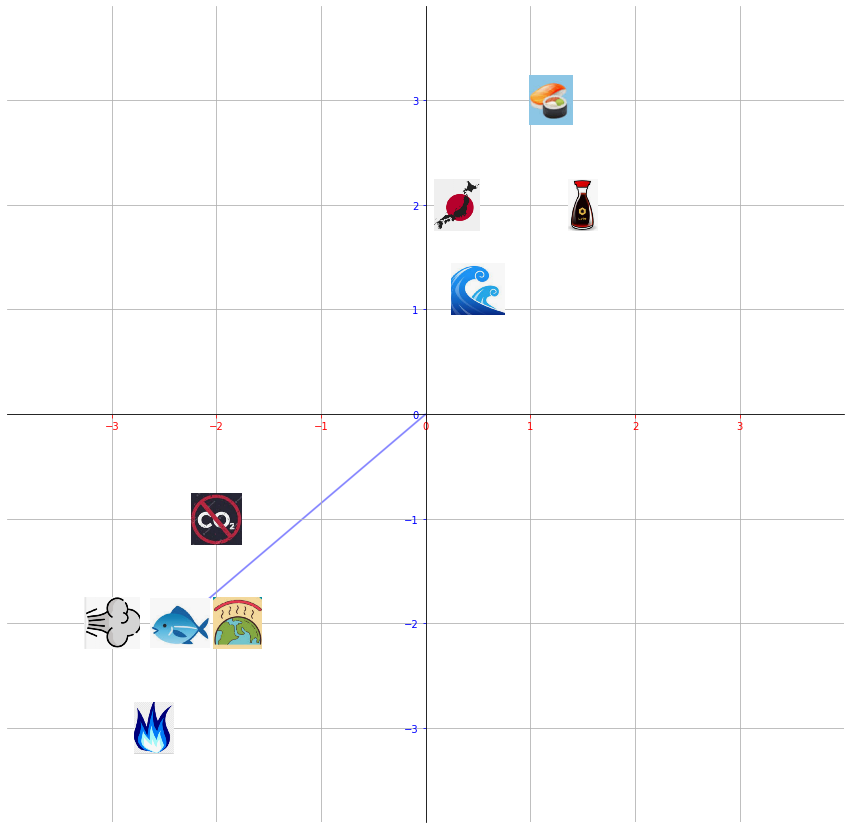

In [66]:
fish_initial_location = np.average(X_cow_neighbor_locations, axis=0)
layout(fish_initial_location)

# Learning

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy_log_loss(X, T):
    """Binary cross entropy log loss function
    Args: 
        X: Signal from sigmoid/logistic function
        T: Label
    """
    # 1/Z where Z = sigmoid(X) = (1/1 + np.exp(-X))
    Z1 = TYPE_FLOAT(1.0) + np.exp(-X, dtype=TYPE_FLOAT)    
    J = np.multiply((TYPE_FLOAT(1.0) - T), X) + np.log(Z1)
    #J = np.squeeze(J, axis=-1)    # Shape from (N,M) to (N,)
    return J

def np_forward_propagate(w, X):
    """Forward propagation to calculate the loss (how far the vector is from the neighbors)
    Args:
        w: vector 
        X: neighbor vectors
    Returns: Scala loss value
    """
    N = len(X)

    # --------------------------------------------------------------------------------
    # Labels
    # --------------------------------------------------------------------------------
    T = [0] * N

    # --------------------------------------------------------------------------------
    # Inner product X@W to measure similarities.
    # --------------------------------------------------------------------------------    
    Y = np.inner(w[np.newaxis, :], X)
    
    # --------------------------------------------------------------------------------
    # Logistic function
    # --------------------------------------------------------------------------------    
    Z = sigmoid(Y)
    
    # --------------------------------------------------------------------------------
    # Binary cross entropy log loss
    # --------------------------------------------------------------------------------
    L = binary_cross_entropy_log_loss(Z, T)
    return np.sum(L) / N

def np_gradient(w, X, T):
    """Gradient of the system (@ -> sigmoid -> loss)"""
    Y = np.einsum("d,nd->n", w, X)
    Z = sigmoid(Y)
    G = np.einsum("nd,n->d", X, (Z-T))
    assert G.shape == w.shape
    return G

@tf.function
def tf_forward_propagate(w, X):
    """Loss function to measure how far the w is away from its neighbours X 
    to which it conceptually belongs to. 
    
    w="fish" is conceptually belngs to the neighbor group of X:[sea, soy, japan, sushi].
    The farther w is away from those neighbor X, the more the loss is.
    
    Args:
        w: vector to measure the distance from the neighbors X.
        X:  array of vectors representing the neighbors of shape (N, D)
    Returns: scala loss value L
    """
    # --------------------------------------------------------------------------------
    # Labels
    # --------------------------------------------------------------------------------
    T = [0] * len(X)

    # --------------------------------------------------------------------------------
    # Inner product X@W to measure similarities.
    # --------------------------------------------------------------------------------
    Y = tf.einsum("d,nd->n", w, X)

    # --------------------------------------------------------------------------------
    # Logistic function
    # --------------------------------------------------------------------------------
    Z = tf.math.sigmoid(Y)

    # --------------------------------------------------------------------------------
    # Binary cross entropy log loss
    # --------------------------------------------------------------------------------
    L = tf.keras.losses.BinaryCrossentropy(from_logits=True)(T, Z)
    
    return L

In [10]:
fish_initial_location = np.average(X_cow_neighbor_locations, axis=0)
print("Loss/TF {}".format(tf_forward_propagate(fish_initial_location, X_cow_neighbor_locations)))
print("Loss/np {}".format(np_forward_propagate(fish_initial_location, X_cow_neighbor_locations)))

2022-01-22 23:16:20.617522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-22 23:16:20.617602: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-22 23:16:20.617643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-01-22 23:16:20.618112: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loss/TF 1.3129844665527344
Loss/np 1.3129844395115464


In [58]:
LR = 0.05
NUM_EPOCH = 150

In [63]:
def gradient_descent(
    vector, 
    positive_neighbors, 
    positive_labels, 
    negative_neighbors, 
    negative_labels, 
    num_epochs, 
    lr, 
    ax=None
):
    w = copy.deepcopy(vector)
    L = []
    for i in range(0, NUM_EPOCH):
        # --------------------------------------------------------------------------------
        # Get closer to positive neighbours
        # ----------------------------------|----------------------------------------------
        L.append(np_forward_propagate(w, positive_neighbors))
        w = w - lr * np_gradient(w, positive_neighbors, positive_labels)

        # --------------------------------------------------------------------------------
        # Get away from negative neighbours
        # --------------------------------------------------------------------------------        
        L.append(np_forward_propagate(w, negative_neighbors))
        w = w - lr * np_gradient(w, negative_neighbors, negative_labels)
        
        # --------------------------------------------------------------------------------
        # Place the new vector
        # --------------------------------------------------------------------------------        
        plot_fish(ax, w, True)
        lr *= 0.985
        
    return w, L

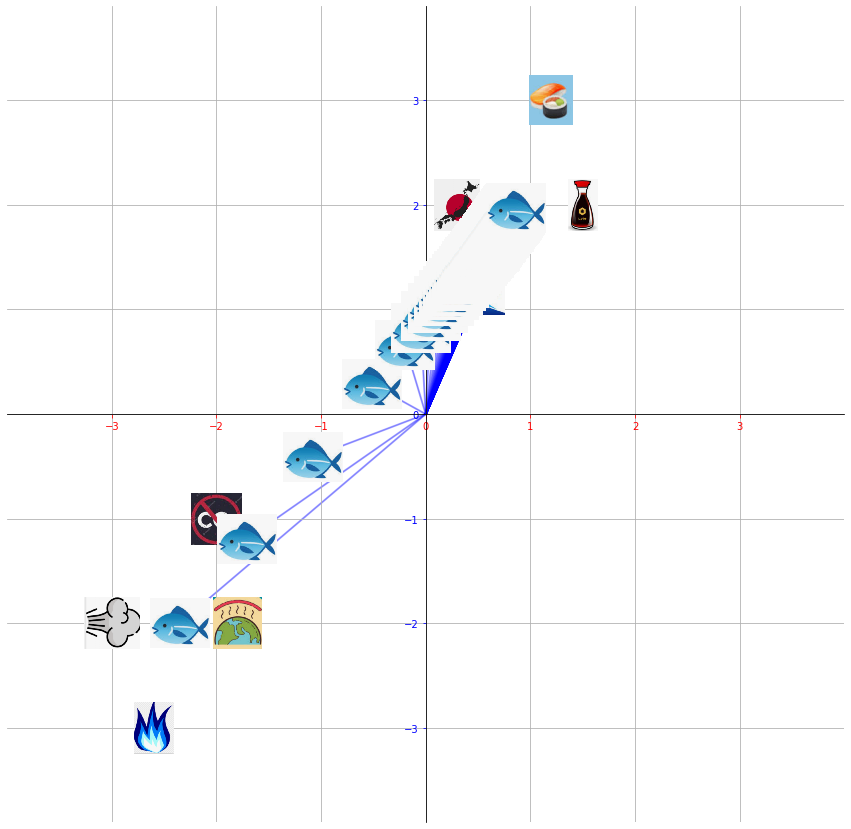

In [64]:
fix, ax = layout(fish_initial_location)
positive_labels = [1] * len(X_cow_neighbor_locations)
negative_labels = [0] * len(X_cow_neighbor_locations)

fish_location, L = gradient_descent(
    fish_initial_location, 
    X_fish_neighbor_locations, 
    positive_labels,
    X_cow_neighbor_locations, 
    negative_labels, 
    NUM_EPOCH, 
    LR, 
    ax
)

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

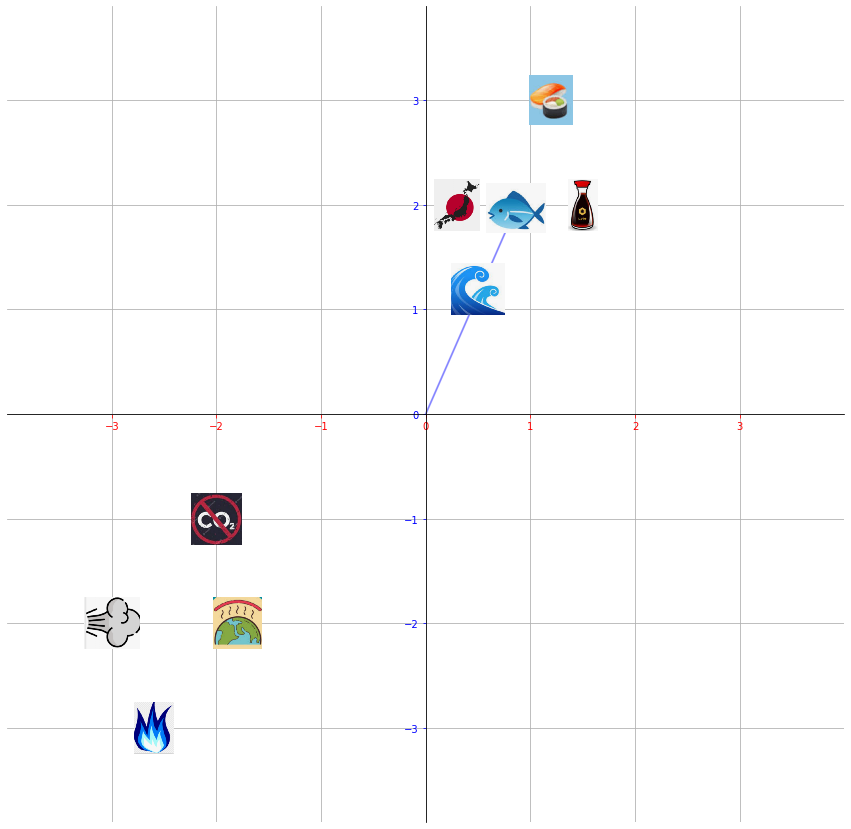

In [67]:
layout(fish_location)